# create labels for 5 classes

In [81]:
from pathlib import Path
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import numpy as np
import time
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity, cosine_distances

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

In [ ]:
# start bert server
!docker start bert-as-service

In [2]:
from bert_serving.client import BertClient
bc = BertClient()

# load dataset with encodings

In [4]:
dataset_path = Path('../../data')

In [5]:
full_ann_df = pd.read_pickle(str(dataset_path/'annotations.pkl'))

In [214]:
ann_df = full_ann_df.copy() #.copy() #.sample(2000) #.iloc[:1000]

In [215]:
ann_df

,sample_id,annotation,encoding
0,1,A person is walking forwards.,"[-0.15791105, -0.016321294, -0.018729901, -0.4..."
1,2,A person walks 4 steps forward.,"[-0.1540823, -0.13345166, 0.07930961, -0.23958..."
2,3,A human walking,"[-0.14400074, -0.495848, -0.48444295, 0.011635..."
3,4,A person walks forward at medium speed.,"[-0.21677037, -0.22117159, 0.023956455, -0.338..."
4,4,human slowly goes forward,"[-0.58368725, -0.18312697, 0.29863808, -0.1279..."
...,...,...,...
6348,3961,a person running and stepipng over one step,"[-0.47801474, -0.1861707, 0.11223907, 0.024005..."
6349,3962,A person runs straight forward.,"[-0.08496222, -0.15005654, -0.46497947, -0.143..."
6350,3964,A person is sprinting up and down a small hill...,"[-0.30929312, -0.17201833, -0.26598853, 0.0950..."
6351,3965,"A person runs forward, briefly touches the gro...","[-0.16391394, 0.08974507, -0.103834555, 0.0485..."


# do PCA

In [216]:
X = np.stack(ann_df.encoding.to_numpy(), axis=0)
print(X.shape)

pca = PCA(n_components=5)
pca_result = pca.fit_transform(np.stack(ann_df.encoding.to_numpy(), axis=0))

ann_df['pca5'] = [np.squeeze(x) for x in np.split(pca_result, pca_result.shape[0])]

(6353, 768)


In [217]:
ann_df.head()

,sample_id,annotation,encoding,pca5
0,1,A person is walking forwards.,"[-0.15791105, -0.016321294, -0.018729901, -0.4...","[-0.8769596, -2.566773, 0.5227943, -0.2748958,..."
1,2,A person walks 4 steps forward.,"[-0.1540823, -0.13345166, 0.07930961, -0.23958...","[1.0850842, -2.0609581, -0.03857765, 1.3153685..."
2,3,A human walking,"[-0.14400074, -0.495848, -0.48444295, 0.011635...","[-3.663657, -1.073499, -1.7742964, 2.2867372, ..."
3,4,A person walks forward at medium speed.,"[-0.21677037, -0.22117159, 0.023956455, -0.338...","[0.3527884, -2.2448514, 0.3786681, 0.089210756..."
4,4,human slowly goes forward,"[-0.58368725, -0.18312697, 0.29863808, -0.1279...","[-0.018056309, -0.6159318, -1.5480042, 4.80203..."


# do k-means clustering

In [218]:
true_k = 5

time_start = time.time()

X = np.stack(ann_df.pca5.to_numpy(), axis=0)
print(X.shape)

kmeans = KMeans(n_clusters=true_k, init='k-means++', max_iter=1000, n_init=10)
# kmeans = KMeans(n_clusters=true_k, init=center_init_arr, max_iter=1, n_init=1)
kmeans.fit(X)
print('k-means done! Time elapsed: {} seconds'.format(time.time()-time_start))

(6353, 5)
k-means done! Time elapsed: 0.16194677352905273 seconds


# compute distances

In [219]:
centers = kmeans.cluster_centers_
v1 = centers[0:2]
v1.shape

(2, 5)

In [220]:
def assign_cluster(vec, centers):
#     dist = euclidean_distances(vec, centers)
    dist = cosine_similarity(vec, centers)
    print(dist)
#     return np.argmin(dist, axis=1)
    return np.argmax(dist, axis=1)
assign_cluster(v1, kmeans.cluster_centers_)

[[ 1.         -0.4191587  -0.19507286 -0.19653706  0.03766906]
 [-0.4191587   1.         -0.3640176   0.02207239 -0.52345186]]


array([0, 1])

In [221]:
prediction = kmeans.predict(X)
# prediction = assign_cluster(X, center_init_arr)
print(prediction[:10])

ann_df['pred'] = prediction

[1 4 1 1 4 4 1 3 4 4]


In [222]:
centroids_df = pd.DataFrame({'pred': list(range(true_k))})
centroids_df['center'] = [centers[x] for x in range(centers.shape[0])]
print(len(centroids_df))
centroids_df

5


,pred,center
0,0,"[0.72765213, 0.79302067, -1.6754, -1.3816979, ..."
1,1,"[-1.6971041, -1.7865852, -0.25732714, 0.246028..."
2,2,"[2.1309347, -0.7688924, 2.1280503, -0.80402875..."
3,3,"[-2.2271597, 1.920077, 0.6521457, 0.15876359, ..."
4,4,"[2.0726771, 0.17814255, -0.080403715, 1.199873..."


In [223]:
len(X)

6353

In [225]:
ann_df.iloc[:5].apply(lambda x: (x.pca5, centers[x.pred,:]), axis=1)

0    ([-0.8769596, -2.566773, 0.5227943, -0.2748958...
1    ([1.0850842, -2.0609581, -0.03857765, 1.315368...
2    ([-3.663657, -1.073499, -1.7742964, 2.2867372,...
3    ([0.3527884, -2.2448514, 0.3786681, 0.08921075...
4    ([-0.018056309, -0.6159318, -1.5480042, 4.8020...
dtype: object

In [226]:
ann_df.iloc[:5].apply(lambda x: (x.pca5.reshape(1, -1).shape, centers[x.pred,:].reshape(1, -1).shape), axis=1)

0    ((1, 5), (1, 5))
1    ((1, 5), (1, 5))
2    ((1, 5), (1, 5))
3    ((1, 5), (1, 5))
4    ((1, 5), (1, 5))
dtype: object

In [227]:
a = ann_df.iloc[:5].pca5.to_list()[0].reshape(1, -1); a.shape, a

((1, 5),
 array([[-0.8769596 , -2.566773  ,  0.5227943 , -0.2748958 , -0.65452063]],
       dtype=float32))

In [228]:
b = centers[3].reshape(1, -1); b.shape, b

((1, 5),
 array([[-2.2271597 ,  1.920077  ,  0.6521457 ,  0.15876359,  0.29817006]],
       dtype=float32))

In [229]:
cosine_similarity(a, b).squeeze().item()

-0.332364946603775

In [230]:
def f(row: pd.Series):
    ann_emb = row.pca5.reshape(1, -1)
    center_emb = centers[row.pred,:].reshape(1, -1)
    similarity = cosine_similarity(ann_emb, center_emb).squeeze().item()
    return similarity
ann_df.iloc[:5].apply(lambda row: f(row), axis=1)

0    0.841280
1    0.552773
2    0.591400
3    0.582435
4    0.299114
dtype: float64

In [231]:
ann_df['similarity'] = ann_df.apply(lambda row: f(row), axis=1)
ann_df

,sample_id,annotation,encoding,pca5,pred,similarity
0,1,A person is walking forwards.,"[-0.15791105, -0.016321294, -0.018729901, -0.4...","[-0.8769596, -2.566773, 0.5227943, -0.2748958,...",1,0.841280
1,2,A person walks 4 steps forward.,"[-0.1540823, -0.13345166, 0.07930961, -0.23958...","[1.0850842, -2.0609581, -0.03857765, 1.3153685...",4,0.552773
2,3,A human walking,"[-0.14400074, -0.495848, -0.48444295, 0.011635...","[-3.663657, -1.073499, -1.7742964, 2.2867372, ...",1,0.591400
3,4,A person walks forward at medium speed.,"[-0.21677037, -0.22117159, 0.023956455, -0.338...","[0.3527884, -2.2448514, 0.3786681, 0.089210756...",1,0.582435
4,4,human slowly goes forward,"[-0.58368725, -0.18312697, 0.29863808, -0.1279...","[-0.018056309, -0.6159318, -1.5480042, 4.80203...",4,0.299114
...,...,...,...,...,...,...
6348,3961,a person running and stepipng over one step,"[-0.47801474, -0.1861707, 0.11223907, 0.024005...","[-0.6542819, -0.019930445, -1.1866707, 1.87813...",1,0.338235
6349,3962,A person runs straight forward.,"[-0.08496222, -0.15005654, -0.46497947, -0.143...","[-0.90604484, -3.1259518, -0.15165244, -0.6446...",1,0.847491
6350,3964,A person is sprinting up and down a small hill...,"[-0.30929312, -0.17201833, -0.26598853, 0.0950...","[0.30881923, -0.81405276, -0.53967345, -1.1948...",0,0.473370
6351,3965,"A person runs forward, briefly touches the gro...","[-0.16391394, 0.08974507, -0.103834555, 0.0485...","[1.052026, 1.4268172, -0.7370955, -0.9441132, ...",0,0.604784


In [232]:
ann_df[ann_df.pred==0].sort_values(by='similarity', ascending=False)

,sample_id,annotation,encoding,pca5,pred,similarity
3403,1352,a person throws something on the grund using h...,"[-0.40024146, 0.1393672, -0.35424662, -0.08084...","[1.5677502, 1.5816152, -3.3927176, -2.583036, ...",0,0.992134
3087,1259,A human performs a hit with a racket with its ...,"[-0.07599705, 0.42318782, -0.19487147, -0.3129...","[1.3914124, 1.6966488, -3.0276449, -3.1207752,...",0,0.985854
3514,1395,a person waves with the left hand,"[-0.7962677, 0.2181239, 0.008710686, -0.254050...","[1.0878714, 1.2345278, -1.9778655, -1.5207345,...",0,0.983098
3528,1401,a person waves with its left hand,"[-0.7047181, 0.33551142, -0.096098855, -0.2206...","[0.9297584, 0.7820642, -2.0113993, -1.453895, ...",0,0.982139
3516,1396,a person waves with its left hand,"[-0.7047181, 0.33551142, -0.096098855, -0.2206...","[0.9297584, 0.7820642, -2.0113993, -1.453895, ...",0,0.982139
...,...,...,...,...,...,...
5370,2099,a human walks on all four.,"[-0.033504616, -0.16125451, -0.22921342, 0.173...","[-0.6187563, 0.32181793, -1.3879111, 0.8503731...",0,0.081024
4719,1853,A person is pushed to the right.,"[-0.8872099, -0.4298315, -0.30260533, -0.11630...","[-0.00085001526, 0.21203849, 1.6945246, -1.529...",0,-0.044835
4585,1810,A person is pushed to the right.,"[-0.8872099, -0.4298315, -0.30260533, -0.11630...","[-0.00085001526, 0.21203849, 1.6945246, -1.529...",0,-0.044835
4697,1849,A person is pushed to the right.,"[-0.8872099, -0.4298315, -0.30260533, -0.11630...","[-0.00085001526, 0.21203849, 1.6945246, -1.529...",0,-0.044835


In [233]:
# np.sort(np.linalg.norm(dist[:5], axis=1))

# analyze/visualize clusters

In [235]:
for x in range(0, true_k):
#     pprint([p for p in preds if p[1]==x][:5])
    print(ann_df[ann_df.pred==x].sort_values(by='similarity', ascending=False)[['annotation', 'similarity']].head())
#     pprint([p for p in preds if p[1]==x][:5])
#     center0_idxs = np.argsort(center_similarity[:, x], axis=0) #[::-1]
#     pprint(ann_df.iloc[center0_idxs].annotation.to_list()[:5])
    print()

                                             annotation  similarity
3403  a person throws something on the grund using h...    0.992134
3087  A human performs a hit with a racket with its ...    0.985854
3514                  a person waves with the left hand    0.983098
3528                  a person waves with its left hand    0.982139
3516                  a person waves with its left hand    0.982139

                    annotation  similarity
5122  A Person is running fast    0.991704
1923           A person walks.    0.989563
4197           A person walks.    0.989563
4047           A person walks.    0.989563
255            A person walks.    0.989563

                                             annotation  similarity
2765         a person walks a quater circle to the left    0.995358
2766              A person taking a 90 degree left turn    0.993760
501   A Person is walking a quarter circle in clockw...    0.985230
2404  A human is walking in a left curve, doing a 90...    0

# visualize, reduce dimensionality (T-SNE)

In [236]:
# pick, and refine centroids/classes

In [237]:
centroids_df

,pred,center
0,0,"[0.72765213, 0.79302067, -1.6754, -1.3816979, ..."
1,1,"[-1.6971041, -1.7865852, -0.25732714, 0.246028..."
2,2,"[2.1309347, -0.7688924, 2.1280503, -0.80402875..."
3,3,"[-2.2271597, 1.920077, 0.6521457, 0.15876359, ..."
4,4,"[2.0726771, 0.17814255, -0.080403715, 1.199873..."


In [238]:
centers

array([[ 0.72765213,  0.79302067, -1.6754    , -1.3816979 , -0.11945223],
       [-1.6971041 , -1.7865852 , -0.25732714,  0.24602889, -0.17973517],
       [ 2.1309347 , -0.7688924 ,  2.1280503 , -0.80402875,  1.6699109 ],
       [-2.2271597 ,  1.920077  ,  0.6521457 ,  0.15876359,  0.29817006],
       [ 2.0726771 ,  0.17814255, -0.08040372,  1.1998738 , -0.908465  ]],
      dtype=float32)

In [239]:
# centroids = kmeans.cluster_centers_
centroids = centers
centroids.shape

(5, 5)

In [240]:
X.shape

(6353, 5)

# append centroids, do t-sne, and then separate them

In [241]:
Xprim = np.concatenate([X, centroids], axis=0)
Xprim.shape

(6358, 5)

In [242]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results_prim = tsne.fit_transform(Xprim[:])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6358 samples in 0.002s...
[t-SNE] Computed neighbors for 6358 samples in 0.273s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6358
[t-SNE] Computed conditional probabilities for sample 2000 / 6358
[t-SNE] Computed conditional probabilities for sample 3000 / 6358
[t-SNE] Computed conditional probabilities for sample 4000 / 6358
[t-SNE] Computed conditional probabilities for sample 5000 / 6358
[t-SNE] Computed conditional probabilities for sample 6000 / 6358
[t-SNE] Computed conditional probabilities for sample 6358 / 6358
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.981064
[t-SNE] KL divergence after 300 iterations: 2.230998
t-SNE done! Time elapsed: 4.868566989898682 seconds


In [243]:
tsne_results = tsne_results_prim[:X.shape[0], :]
centroids_results = tsne_results_prim[X.shape[0]:, :]
tsne_results.shape, centroids_results.shape

((6353, 2), (5, 2))

In [244]:
# centroids_df = pd.DataFrame({'pred': list(range(true_k))})
centroids_df['tsne1'] = centroids_results[:,0]
centroids_df['tsne2'] = centroids_results[:,1]
centroids_df['size'] = 20
centroids_df

,pred,center,tsne1,tsne2,size
0,0,"[0.72765213, 0.79302067, -1.6754, -1.3816979, ...",-2.413588,8.254965,20
1,1,"[-1.6971041, -1.7865852, -0.25732714, 0.246028...",-3.068930,-6.722996,20
2,2,"[2.1309347, -0.7688924, 2.1280503, -0.80402875...",9.988832,-1.477928,20
3,3,"[-2.2271597, 1.920077, 0.6521457, 0.15876359, ...",-8.881405,1.124196,20
4,4,"[2.0726771, 0.17814255, -0.080403715, 1.199873...",5.343307,5.323734,20


In [245]:
centroids_df.tsne1.min(), centroids_df.tsne1.max()

(-8.881405, 9.988832)

In [246]:
centroids_df.tsne2.min(), centroids_df.tsne2.max()

(-6.7229958, 8.254965)

In [247]:
ann_df['tsne1'] = tsne_results[:,0]
ann_df['tsne2'] = tsne_results[:,1]
ann_df

,sample_id,annotation,encoding,pca5,pred,similarity,tsne1,tsne2
0,1,A person is walking forwards.,"[-0.15791105, -0.016321294, -0.018729901, -0.4...","[-0.8769596, -2.566773, 0.5227943, -0.2748958,...",1,0.841280,4.294674,-10.082913
1,2,A person walks 4 steps forward.,"[-0.1540823, -0.13345166, 0.07930961, -0.23958...","[1.0850842, -2.0609581, -0.03857765, 1.3153685...",4,0.552773,5.227407,-6.333350
2,3,A human walking,"[-0.14400074, -0.495848, -0.48444295, 0.011635...","[-3.663657, -1.073499, -1.7742964, 2.2867372, ...",1,0.591400,-7.115023,-8.713981
3,4,A person walks forward at medium speed.,"[-0.21677037, -0.22117159, 0.023956455, -0.338...","[0.3527884, -2.2448514, 0.3786681, 0.089210756...",1,0.582435,3.719619,-5.925188
4,4,human slowly goes forward,"[-0.58368725, -0.18312697, 0.29863808, -0.1279...","[-0.018056309, -0.6159318, -1.5480042, 4.80203...",4,0.299114,0.088827,-0.425633
...,...,...,...,...,...,...,...,...
6348,3961,a person running and stepipng over one step,"[-0.47801474, -0.1861707, 0.11223907, 0.024005...","[-0.6542819, -0.019930445, -1.1866707, 1.87813...",1,0.338235,0.616131,-2.576702
6349,3962,A person runs straight forward.,"[-0.08496222, -0.15005654, -0.46497947, -0.143...","[-0.90604484, -3.1259518, -0.15165244, -0.6446...",1,0.847491,1.282756,-9.886319
6350,3964,A person is sprinting up and down a small hill...,"[-0.30929312, -0.17201833, -0.26598853, 0.0950...","[0.30881923, -0.81405276, -0.53967345, -1.1948...",0,0.473370,1.589006,-4.808942
6351,3965,"A person runs forward, briefly touches the gro...","[-0.16391394, 0.08974507, -0.103834555, 0.0485...","[1.052026, 1.4268172, -0.7370955, -0.9441132, ...",0,0.604784,0.224365,5.439255


In [248]:
ann_df.pred.value_counts()

1    1661
4    1427
3    1242
0    1202
2     821
Name: pred, dtype: int64

In [249]:
ann_df.tsne1.min(), ann_df.tsne1.max()

(-12.545307, 13.729485)

In [250]:
ann_df.tsne2.min(), ann_df.tsne2.max()

(-12.647444, 12.0108185)

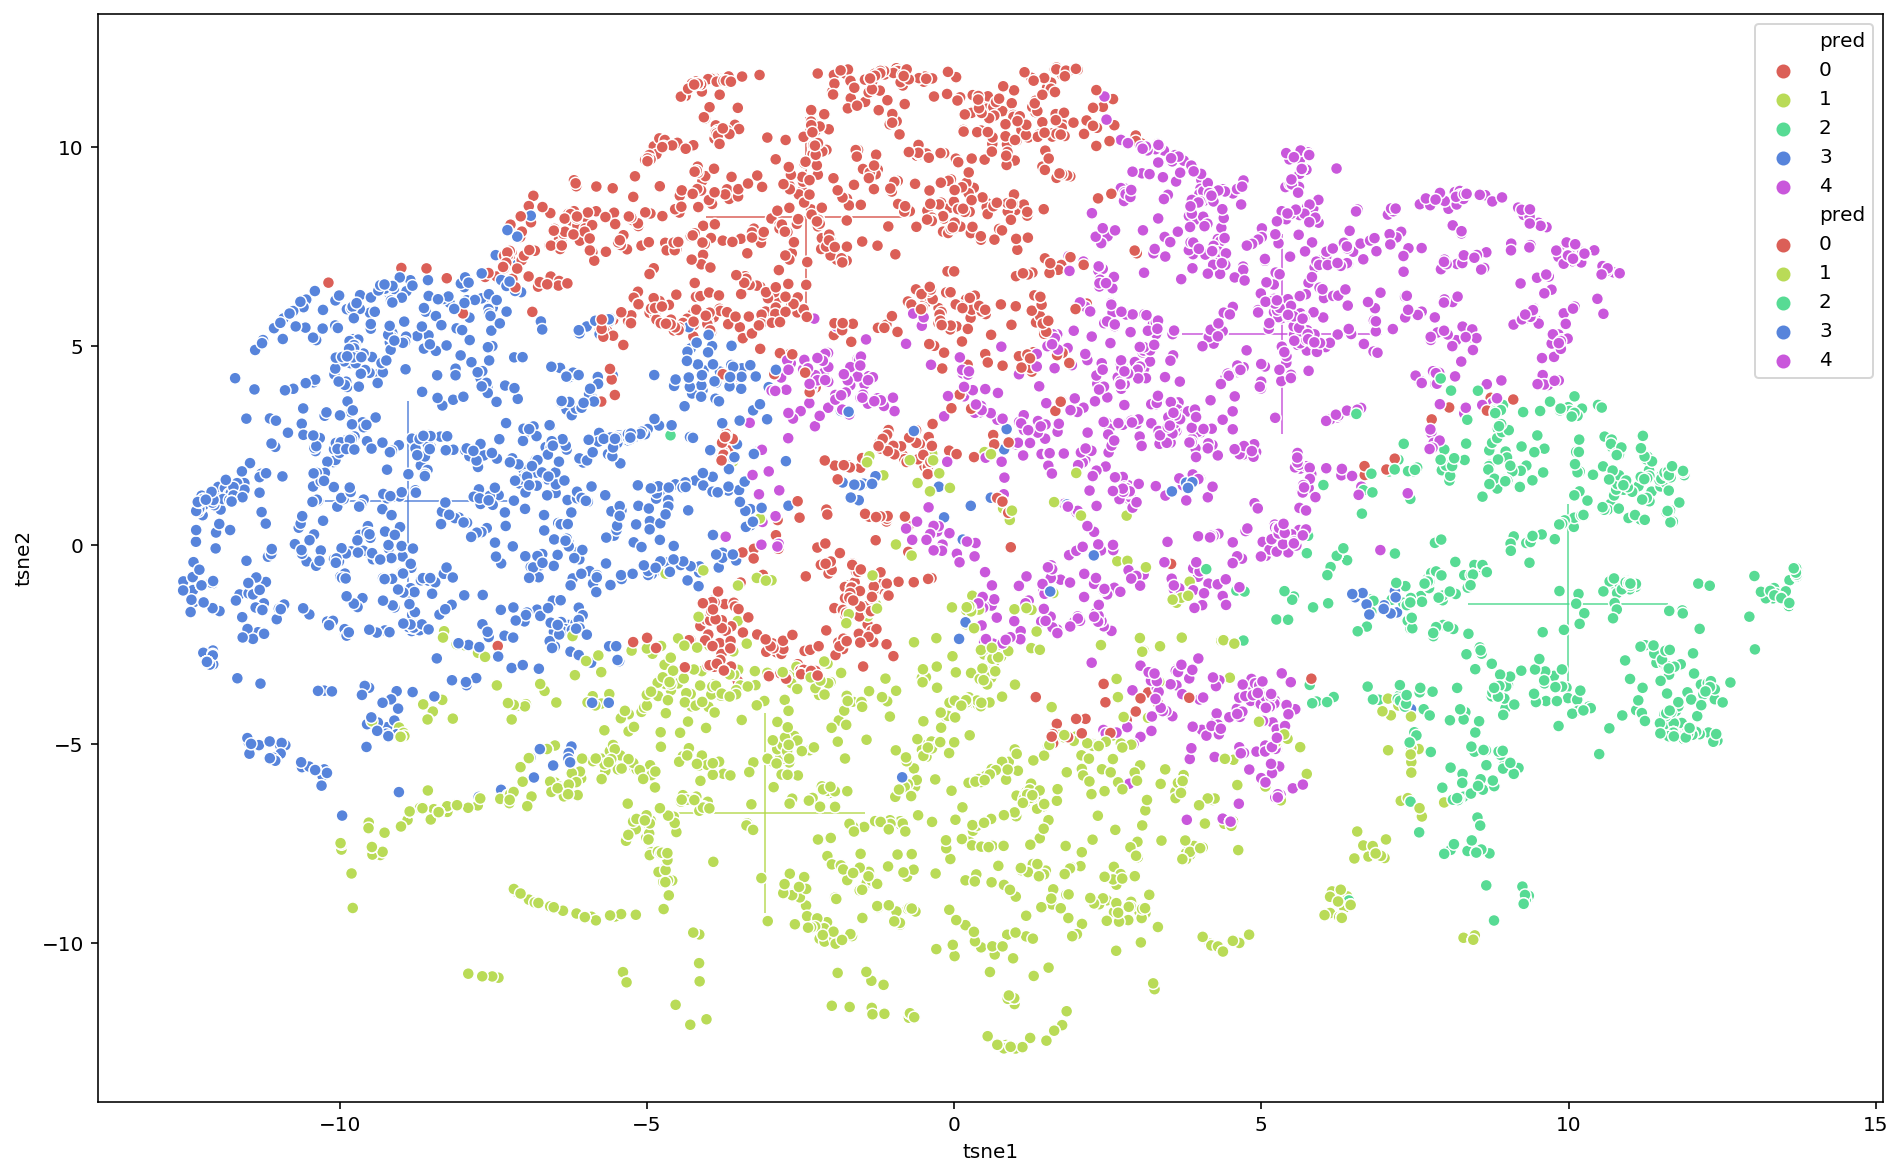

In [251]:
plt.figure(figsize=(16,10))

# plot centroids
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="pred",
    palette=sns.color_palette("hls", true_k),
    data=centroids_df,
    legend="full",
    s=10000,
    marker="+",
    alpha=1.0
);

# plot samples
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="pred",
    palette=sns.color_palette("hls", true_k),
    data=ann_df,
    legend="full",
    alpha=1.0
);